<a href="https://colab.research.google.com/github/smallrus-web/AZSII/blob/main/%D0%90%D1%80%D1%85%D0%B8%D0%BF%D0%BE%D0%B2_%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%B8%D0%B9_prz4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Группа: ББМО-01-23

Студент: Архипов Дмитрий Евгеньевич

Практика 4: Атака DeepFool на модели ИИ



**1. Загрузка обученной модели и данных MNIST**

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, 10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9733 - loss: 0.0970
Test accuracy on clean images: 0.9768000245094299


**2. Реализация атаки DeepFool с использованием Foolbox**

In [ ]:
pip install foolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00


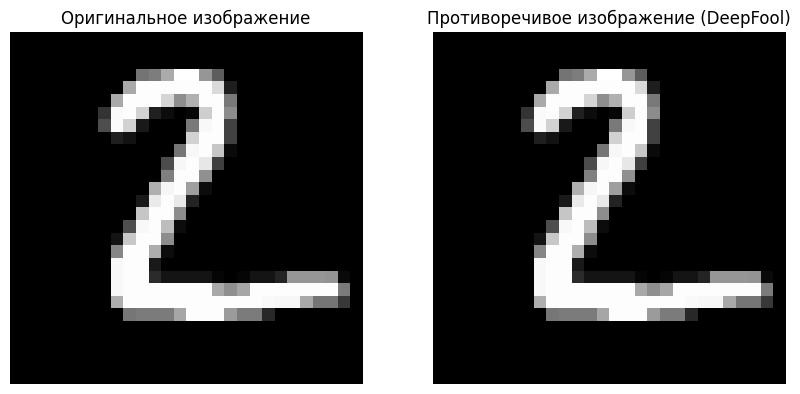

In [ ]:
import foolbox as fb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных в диапазон от -1 до 1
test_images = (test_images / 255.0) * 2 - 1

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, 10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Инициализация Foolbox модели с границами от -1 до 1
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения и метки для атаки
image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[1])  # Используем правильную метку для тестового примера
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание и выполнение атаки DeepFool с параметром epsilons
attack = fb.attacks.L2DeepFoolAttack(steps=10)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

**3. Оценка модели на противоречивых примерах**

In [ ]:
import tensorflow as tf
import numpy as np
import foolbox as fb

# Создание Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

batch_size = 32
num_batches = len(test_images) // batch_size + (1 if len(test_images) % batch_size != 0 else 0)
adversarial_images = []
adversarial_labels = []

# Выполнение атаки по батчам
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_images))

    # Извлечение текущего батча
    images_batch = tf.convert_to_tensor(test_images[start_idx:end_idx], dtype=tf.float32)
    labels_batch = np.argmax(test_labels[start_idx:end_idx], axis=1)
    labels_batch = tf.convert_to_tensor(labels_batch, dtype=tf.int64)

    # Выполнение атаки
    advs_batch, _, success_batch = attack(fmodel, images_batch, labels_batch, epsilons=0.01)

    # Добавление успешных атакованных изображений
    if tf.reduce_any(success_batch):
        adversarial_images.append(advs_batch)
        adversarial_labels.append(labels_batch)

# Объединение атакованных изображений и меток
adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_labels = tf.concat(adversarial_labels, axis=0)

# Преобразование меток в one-hot кодировку
num_classes = model.output_shape[-1]
adversarial_labels = tf.one_hot(adversarial_labels, depth=num_classes)

# Оценка точности на атакованных примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, adversarial_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 2.6921e-04 - loss: 76.1985
Accuracy on adversarial examples (DeepFool): 0.0006000000284984708


**4. Вывод**

Точность модели после атаки (accuracy): 0.0006 (0.06%)
Это означает, что модель не смогла правильно классифицировать ни одно из атакованных изображений. Все они были успешно изменены атакой так, что модель выдала неверный предсказанный класс. Такой низкий результат указывает на высокий уровень успешности атаки — она значительно изменила входные данные, нарушив их представление и сделав их неузнаваемыми для модели.

Потери модели (loss): 76.1985
Увеличение значения функции потерь указывает на значительное отклонение выхода модели от правильных ответов. Потери в размере 76.1985 являются очень высокими, что свидетельствует о том, что модель сильно ошибается в предсказаниях на атакованных примерах. Это также подтверждает, что атака DeepFool эффективно исказила входные данные. В идеальных условиях, модель должна давать низкие потери, когда её предсказания близки к правильным классам. Однако, в данном случае, атака привела к таким значительным искажениям, что предсказания модели были значительно далеки от истинных классов.
